In [7]:
from datasets import load_dataset

category = 'py'
df = load_dataset('JetBrains-Research/template-generation', category, split='dev')

In [8]:
import ast

df = df.map(lambda example: {'topics': ast.literal_eval(example['topics'])}, batched=False)


In [9]:
topics_to_check = ['fastapi', 'django', 'flask']


def classify_by_topic(dp):
    class_topic = None
    
    for topic in dp['topics']:
        if topic in topics_to_check:
            if class_topic is None:
                class_topic = topic
            else:
                return {'class_topic': None}

    return {'class_topic': class_topic}


def class_topic_not_none(example):
    return example['class_topic'] is not None


df = df.map(classify_by_topic)
df = df.filter(class_topic_not_none)

Map:   0%|          | 0/1070 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1070 [00:00<?, ? examples/s]

In [10]:
df

Dataset({
    features: ['id', 'full_name', 'owner', 'name', 'html_url', 'is_template', 'description', 'template_keywords', 'license', 'topics', 'size', 'metrics', 'languages', 'language', 'created_at', 'updated_at', 'code_lines', 'gpt_description', 'class_topic'],
    num_rows: 129
})

In [11]:
from collections import Counter

Counter(df['class_topic'])

Counter({'django': 55, 'fastapi': 46, 'flask': 28})

In [12]:
repos_path = '/Users/Maria.Tigina/PycharmProjects/agents-eval-data/repos'

In [199]:
from git import Repo

for dp in df:
    Repo.clone_from(f'https://github.com/{dp["full_name"]}.git',
                    f'{repos_path}/{"__".join(dp["full_name"].split("/"))}')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [59]:
!pip install tree-sitter

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [204]:
!git clone https://github.com/tree-sitter/tree-sitter-python

Cloning into 'tree-sitter-python'...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


remote: Enumerating objects: 3189, done.
remote: Counting objects: 100% (1366/1366), done.
remote: Compressing objects: 100% (220/220), done.[K
remote: Total 3189 (delta 1182), reused 1247 (delta 1136), pack-reused 1823
Receiving objects: 100% (3189/3189), 21.55 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (1962/1962), done.


In [212]:
# !cd tree-sitter-python & npm install & npx tree-sitter generate

In [13]:
import fnmatch
import os
from tree_sitter import Language, Parser

Language.build_library("build/my-languages.so", ["tree-sitter-python"])
java_language = Language("build/my-languages.so", "python")
parser = Parser()
parser.set_language(java_language)


def get_nodes_by_type(node, t: str):
    t_nodes = []
    if node.type == t:
        t_nodes.append(node)
    else:
        for child in node.children:
            t_nodes.extend(get_nodes_by_type(child, t))
    return t_nodes


def get_node_content(node, code):
    start_byte = node.start_byte
    end_byte = node.end_byte
    return code[start_byte:end_byte]


def extract_methods_from_code(code: str, language: str):
    node_t_by_language = {
        "py": 'function_definition',
        "java": 'method_declaration'
    }

    t = node_t_by_language[language]
    tree = parser.parse(code)
    all_methods = get_nodes_by_type(tree.root_node, t)
    method_contents = []
    for method in all_methods:
        method_content = get_node_content(method, code)
        method_contents.append(method_content)

    return method_contents


def get_repo_files(directory: str, extension: str):
    for root, dir, files in os.walk(directory):
        for file in files:
            if fnmatch.fnmatch(file, f"*.{extension}"):
                yield os.path.join(root, file)

/Users/Maria.Tigina/PycharmProjects/agents-eval/venv/lib/python3.11/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language.build_library is deprecated. Use the new bindings instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)
/Users/Maria.Tigina/PycharmProjects/agents-eval/venv/lib/python3.11/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np

vect = {}
for entity in ['files', 'methods']:
    vect[entity] = {
        'content': [],
        'repo': [],
        'path': [],
        'vects': np.empty((0, 1024)),
        'class': []
    }

for dp in df:
    repo = dp['full_name']
    for file in get_repo_files(os.path.join(repos_path, "__".join(dp["full_name"].split("/"))), category):
        with open(file, 'r') as f:
            file_content = f.read()
            vect['files']['content'].append(file_content)
            vect['files']['repo'].append(repo)
            vect['files']['path'].append(file)
            vect['files']['class'].append(dp['class_topic'])

            source_code = bytes(file_content, "utf8")
            methods = extract_methods_from_code(source_code, category)
            for method in methods:
                vect['methods']['content'].append(method)
                vect['methods']['repo'].append(repo)
                vect['methods']['path'].append(file)
                vect['methods']['class'].append(dp['class_topic'])

model = SentenceTransformer('thenlper/gte-large')

for entity in ['files', 'methods']:
    vect[entity]['vects'] = model.encode(vect[entity]['content'])
    print(vect[entity]['vects'].shape)
    print(len(vect[entity]['content']))
    print(len(vect[entity]['path']))


(3012, 1024)
3012
3012
(5761, 1024)
5761
5761


In [36]:
import collections
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def classify(classifier, entity: str):
    clusters = classifier.fit_predict(vect[entity]['vects'])
    cluster_counts = collections.Counter(clusters)

    large_clusters = {cluster: count for cluster, count in cluster_counts.items()}
    print(large_clusters)

    df_labels = pd.DataFrame({
        'label': clusters,
        'repo': vect[entity]['repo'],
        'path': vect[entity]['path'], 
        'content': vect[entity]['content'], 
        'class': vect[entity]['class']
    })
    
    tsne = TSNE(n_components=2, random_state=0)  # 2D t-SNE
    methods_tsne = tsne.fit_transform(vect[entity]['vects'])
    
    # plot the result
    plt.figure(figsize=(8, 8))
    plt.scatter(
        methods_tsne[:, 0],
        methods_tsne[:, 1],
        c=clusters,
        cmap='viridis'
    )
    plt.show()
    
    for c in large_clusters.keys():
        print(f"Class {c}:")
        # print(*list(df_labels[df_labels['label'] == c]['repo']), sep='\n')
        print(collections.Counter(df_labels[df_labels['label'] == c]['class']))
        # for _, dp in df_labels[df_labels['label'] == c].iterrows():
        #     print(dp['path'])
        #     print(dp['content'])
        #     print('------------------------------------\n\n')
        print("====================================\n\n")

{0: 4838, 1: 923}


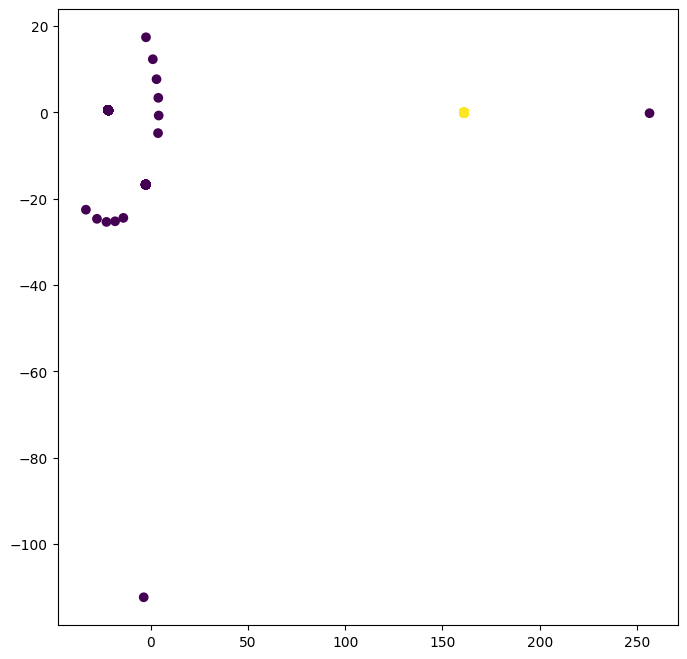

Class 0:
Counter({'django': 1861, 'fastapi': 1582, 'flask': 1395})


Class 1:
Counter({'fastapi': 847, 'flask': 76})



In [38]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=3)
classify(dbscan, 'methods')

In [33]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
classify(kmeans, 'methods')

{0: 4837, 1: 923, 2: 1}
Class 0:
Counter({'django': 1861, 'fastapi': 1581, 'flask': 1395})


Class 1:
Counter({'fastapi': 847, 'flask': 76})


Class 2:
Counter({'fastapi': 1})
